<a href="https://colab.research.google.com/github/andersonsam/cnn_lstm_era_hindcast/blob/main/glacier_PC_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

In [1]:
# Colab can access/save data stored in google drive.  Here is the directory structure in google drive -- set this up before running code

# My Drive/
# |__ Colab Notebooks/
#     |__ cnn_lstm_era/
#         |__ data/
#         |__ models/
#         |__ output/
#         |__ heat_maps/

dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs

dir_models_north = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models_north' #where to save trained models
dir_output_north = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output_north' #where to save trained model outputs


In [2]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3
!pip install pymannkendall

     |████████████████████████████████| 994 kB 7.7 MB/s 
     |████████████████████████████████| 6.3 MB 48.5 MB/s 
     |████████████████████████████████| 15.4 MB 61.5 MB/s 
     |████████████████████████████████| 610 kB 8.0 MB/s 


In [3]:
#import required libraries

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import path, cm#, colors
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
from scipy.stats import ks_2samp, pearsonr
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import pickle
import os
from random import seed
from datetime import datetime, date, timedelta
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive
import pymannkendall as mk

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [4]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#define functions

def gaussian(x):
  y = np.exp(-x**2/2)
  return y

def get_seasonal_inds_from_list(date_list):

  """
  From a list of dates, return the indices of each season.
  """

  m = np.array([d.month for d in date_list])
  inds_DJF = np.squeeze(np.argwhere((m == 12) | (m ==  1) | (m ==  2)))
  inds_MAM = np.squeeze(np.argwhere((m ==  3) | (m ==  4) | (m ==  5)))
  inds_JJA = np.squeeze(np.argwhere((m ==  6) | (m ==  7) | (m ==  8)))
  inds_SON = np.squeeze(np.argwhere((m ==  9) | (m == 10) | (m == 11)))

  return inds_DJF, inds_MAM, inds_JJA, inds_SON

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def rmse(y_model, y_obs):

  RMSE = np.sqrt( np.nanmean( (y_model - y_obs)**2 ) )

  return RMSE

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

# Prep data: 1979 - 2015

In [6]:
#load data

prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

# flowpickle = ['BC_flowvars_1979_2020_missing_40_40_1.pickle', 'AB_flowvars_1979_2020_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle'

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#load daily evaporation data
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
evapDict = pickle.load(pickle_in)

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_modern = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

F = flowDict['all_flow_NF'] 
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])
E = np.asarray(evapDict['E'])
PE = P+E

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [7]:
del tempDict, precDict

In [8]:
#select subset of stations

# maxLat = 60#56. #maximum station latitude to include
stationInds_north = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)>56.)[:,0]) #indices of stations which are in the northern models
stationInds_south = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)<=56.)[:,0]) #indices of stations which are in the southern models
stationInds = np.arange(len(stationInds_north) + len(stationInds_south))

F = np.asarray(F) #restructure F to be an array where rows are days and columns are stations
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds] #only use basins where stations are south of the maximum latitude

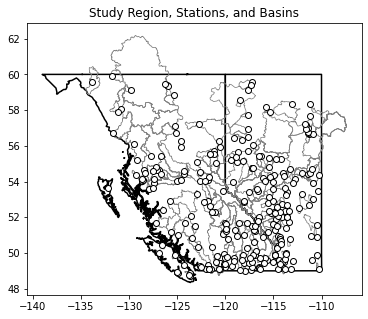

In [9]:
#visualize study region

saveIt = 0

fig, ax = plt.subplots(figsize = (6,5))

plot_prov_ax(prov, ax)
for basin in stationBasins:
  if basin is not None:
    x,y = basin.exterior.xy
    ax.plot(x, y, color = 'gray', linewidth = 0.75)
ax.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', zorder = 3)
ax.set_title('Study Region, Stations, and Basins')

if saveIt:
  plt.savefig('study_region.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [10]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

### SOUTH

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds_south])
  maxLon = np.max(stationLon[stationInds_south])
  minLat = np.min(stationLat[stationInds_south])
  maxLat = np.max(stationLat[stationInds_south])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA_south = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA_south = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA_south = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA_south = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA_south + border > len(eraLat) - 1:
    indMinLatERA_south = len(eraLat) - 1
  else:
    indMinLatERA_south = indMinLatERA_south + border

  if indMaxLatERA_south - border < 1:
    indMaxLatERA_south = 0
  else:
    indMaxLatERA_south = indMaxLatERA_south - border + 1

  if indMaxLonERA_south + border > len(eraLon) - 1:
    indMaxLonERA_south = len(eraLon) - 1
  else:
    indMaxLonERA_south = indMaxLonERA_south + border

  if indMinLonERA_south - border < 1:
    indMinLonERA_south = 0
  else:
    indMinLonERA_south = indMinLonERA_south - border

  #trim temp/precip data to only those values within bounding box
  Tmax_south = Tmax[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
  Tmin_south = Tmin[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
  P_south = P[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
  E_south = E[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
  PE_south = PE[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA_south = [eraLon[indMinLonERA_south] - d_eraLon/2,eraLon[indMaxLonERA_south] + d_eraLon/2,eraLat[indMinLatERA_south] - d_eraLat/2,eraLat[indMaxLatERA_south] + d_eraLat/2]
  eraLon_south = eraLon[indMinLonERA_south:indMaxLonERA_south+1]
  eraLat_south = eraLat[indMaxLatERA_south:indMinLatERA_south+1]

### NORTH

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds_north])
  maxLon = np.max(stationLon[stationInds_north])
  minLat = np.min(stationLat[stationInds_north])
  maxLat = np.max(stationLat[stationInds_north])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA_north = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA_north = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA_north = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA_north = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA_north + border > len(eraLat) - 1:
    indMinLatERA_north = len(eraLat) - 1
  else:
    indMinLatERA_north = indMinLatERA_north + border

  if indMaxLatERA_north - border < 1:
    indMaxLatERA_north = 0
  else:
    indMaxLatERA_north = indMaxLatERA_north - border + 1

  if indMaxLonERA_north + border > len(eraLon) - 1:
    indMaxLonERA_north = len(eraLon) - 1
  else:
    indMaxLonERA_north = indMaxLonERA_north + border

  if indMinLonERA_north - border < 1:
    indMinLonERA_north = 0
  else:
    indMinLonERA_north = indMinLonERA_north - border

  #trim temp/precip data to only those values within bounding box
  Tmax_north = Tmax[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
  Tmin_north = Tmin[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
  P_north = P[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
  E_north = E[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
  PE_north = PE[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA_north = [eraLon[indMinLonERA_north] - d_eraLon/2,eraLon[indMaxLonERA_north] + d_eraLon/2,eraLat[indMinLatERA_north] - d_eraLat/2,eraLat[indMaxLatERA_north] + d_eraLat/2]
  eraLon_north = eraLon[indMinLonERA_north:indMaxLonERA_north+1]
  eraLat_north = eraLat[indMaxLatERA_north:indMinLatERA_north+1]

In [11]:
#years/indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015
testFinYear = 2020

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

In [12]:
#NORTH: standardize data relative to training time period

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train_north = np.mean([Tmax_north[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train_north = np.std([Tmax_north[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm_north = (Tmax_north - Tmaxmean_train_north)/Tmaxstd_train_north
Tmaxnorm_north = np.single(Tmaxnorm_north)

Tminmean_train_north = np.mean([Tmin_north[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train_north = np.std([Tmin_north[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm_north = (Tmin_north - Tminmean_train_north)/Tminstd_train_north
Tminnorm_north = np.single(Tminnorm_north)

Pmean_train_north = np.mean([P_north[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train_north = np.std([P_north[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm_north = (P_north - Pmean_train_north)/Pstd_train_north
Pnorm_north = np.single(Pnorm_north)

#normalize flow wrt to training period for each station
F_north = F[:,stationInds_north]
Fnorm_north = np.empty_like(F_north)
Fmean_north = np.zeros(len(stationInds_north))
Fstd_north = np.zeros(len(stationInds_north))
for station in range(np.shape(Fnorm_north)[1]):
  Fmean_north[station] = np.mean(F_north[trainInds,station])
  Fstd_north[station] = np.std(F_north[trainInds,station])
  Fnorm_north[:,station] = (F_north[:,station] - Fmean_north[station]) / Fstd_north[station]

In [13]:
#SOUTH: standardize data relative to training time period

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train_south = np.mean([Tmax_south[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train_south = np.std([Tmax_south[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm_south = (Tmax_south - Tmaxmean_train_south)/Tmaxstd_train_south
Tmaxnorm_south = np.single(Tmaxnorm_south)

Tminmean_train_south = np.mean([Tmin_south[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train_south = np.std([Tmin_south[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm_south = (Tmin_south - Tminmean_train_south)/Tminstd_train_south
Tminnorm_south = np.single(Tminnorm_south)

Pmean_train_south = np.mean([P_south[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train_south = np.std([P_south[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm_south = (P_south - Pmean_train_south)/Pstd_train_south
Pnorm_south = np.single(Pnorm_south)



#normalize flow wrt to training period for each station
F_south = F[:,stationInds_south]
Fnorm_south = np.empty_like(F_south)
Fmean_south = np.zeros(len(stationInds_south))
Fstd_south = np.zeros(len(stationInds_south))
for station in range(np.shape(Fnorm_south)[1]):
  Fmean_south[station] = np.mean(F_south[trainInds,station])
  Fstd_south[station] = np.std(F_south[trainInds,station])
  Fnorm_south[:,station] = (F_south[:,station] - Fmean_south[station]) / Fstd_south[station]

Fmean = np.zeros(len(stationInds))
Fmean[stationInds_north] = Fmean_north
Fmean[stationInds_south] = Fmean_south

Fstd = np.zeros(len(stationInds))
Fstd[stationInds_north] = Fstd_north
Fstd[stationInds_south] = Fstd_south

# Cluster seasonal flow: 1979 - 2015

In [14]:
#SOUTH : create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.empty((len(stationInds_south), len_input))

flowseason_south = flowDict['all_flowseason_NF'][stationInds_south,:]
stationLat_norm = (stationLat[stationInds_south] - np.mean(stationLat[stationInds_south])) / np.std(stationLat[stationInds_south])
stationLon_norm = (stationLon[stationInds_south] - np.mean(stationLon[stationInds_south])) / np.std(stationLon[stationInds_south])

for station in range(len(stationInds_south)):
  cluster_input[station,:365] = (flowseason_south[station,:] - np.mean(flowseason_south[station,:])) / np.std(flowseason_south[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal_south = 6
seasonal_clustering_south = AgglomerativeClustering(n_clusters = n_clusters_seasonal_south).fit(cluster_input)

#calculate average of each cluster
cluster_patterns_south = np.empty((n_clusters_seasonal_south, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal_south):
  cluster_inds = np.argwhere(seasonal_clustering_south.labels_ == cluster)
  cluster_patterns_south[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [15]:
#NORTH : create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.empty((len(stationInds_north), len_input))

flowseason_north = flowDict['all_flowseason_NF'][stationInds_north,:]
stationLat_norm = (stationLat[stationInds_north] - np.mean(stationLat[stationInds_north])) / np.std(stationLat[stationInds_north])
stationLon_norm = (stationLon[stationInds_north] - np.mean(stationLon[stationInds_north])) / np.std(stationLon[stationInds_north])

for station in range(len(stationInds_north)):
  cluster_input[station,:365] = (flowseason_north[station,:] - np.mean(flowseason_north[station,:])) / np.std(flowseason_north[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal_north = 2
seasonal_clustering_north = AgglomerativeClustering(n_clusters = n_clusters_seasonal_north).fit(cluster_input)

#calculate average of each cluster
cluster_patterns_north = np.empty((n_clusters_seasonal_north, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal_north):
  cluster_inds = np.argwhere(seasonal_clustering_north.labels_ == cluster)
  cluster_patterns_north[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [16]:
#cluster all together now

flowseason = np.zeros((len(stationInds), 365))
flowseason[stationInds_south] = flowseason_south
flowseason[stationInds_north] = flowseason_north

flowseason_norm = np.zeros((len(stationInds), 365))

for station in range(len(flowseason)):
  flowseason_norm[station,:] = ( flowseason[station,:] - np.mean(flowseason[station,:]) ) / np.std(flowseason[station,:])

stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

cluster_input = np.empty((len(stationInds), len_input))
for station in range(len(stationInds)):
  cluster_input[station,:365] = flowseason_norm[station,:] #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

labels = seasonal_clustering.labels_

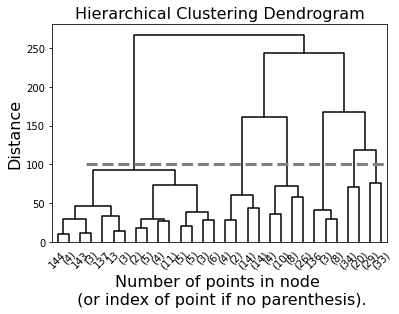

In [17]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)


# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
cutoff = 100
linemin = 30
linemax = 310
plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [18]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#assign geographically relevant names for each cluster
cluster_names = [
                 'Central',       #cluster 0
                 'Southern',      #cluster 1
                 'Eastern',       #etc
                 'Coastal',
                 'North-Western',
                 'North-Eastern',
                 'Far North-West',
                 'Far North-East'
]

cluster_names = [
                 'North-Western',       #cluster 0
                 'Southern',      #cluster 1
                 'North-Eastern',       #etc
                 'Coastal',
                 'Eastern',
                 'Central'
]

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

first_days_of_month = np.array([1,32,61,92,122,153,183,214,245,275,306,336]) #day-of-year of the first day of each month

months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.5, 1.0, 'Clusters in Space')

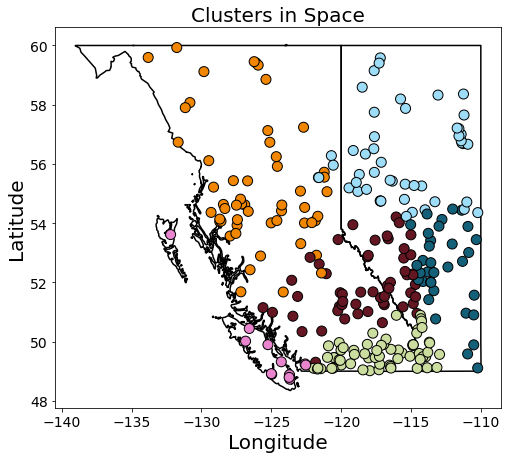

In [19]:
#visualize clustering results (spatial patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig, ax = plt.subplots(figsize = (8,7))

#left side: spatial map of stations, coloured by cluster to which they belong
plot_prov_ax(prov=prov, ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax.tick_params(labelsize = fs-6)
ax.set_xlabel('Longitude', fontsize = fs)
ax.set_ylabel('Latitude', fontsize = fs)
ax.set_title('Clusters in Space', fontsize = fs)


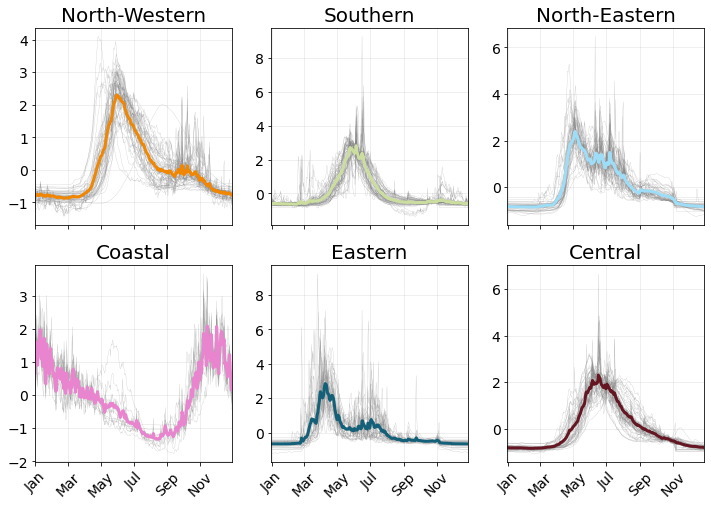

In [20]:
#temporal patterns

nrows = 2
ncols = int(np.ceil(n_clusters_seasonal/2))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*4, nrows*4))

for cluster, ax in enumerate(axes.flatten()):

  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_xticklabels(months_str[::2], rotation = 45)#, ha = 'right')
  if cluster<3:
    ax.set_xticklabels([])
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.tick_params(labelsize = fs - 6)
  ax.set_title(cluster_names[cluster], fontsize = fs)
  ax.grid(True, alpha = 0.25)

plt.show()

# Predict warm / cold / wet / dry

In [28]:
#SOUTHERN TEMPERATURE PERTURBATIONS

load_files = 1 #0 == do calculations, 1 == load model predictions

T_perturbs = [-1,0,1]

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]
# runs = [0]

Nruns = len(runs)
Nstations = len(stationInds)
Nstations_south = len(stationInds_south)
Nperturbs_T = len(T_perturbs)

#target data
y_train_south = np.squeeze([Fnorm_south[365:trainInds[-1]+1,ii] for ii in range(np.shape(F_south)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val_south = np.squeeze([Fnorm_south[valInds,ii] for ii in range(np.shape(F_south)[1])]).T
y_test_south = np.squeeze([Fnorm_south[testInds,ii] for ii in range(np.shape(F_south)[1])]).T

y_train_south = y_train_south.astype(dtype = np.float16)
y_val_south = y_val_south.astype(dtype = np.float16)
y_test_south = y_test_south.astype(dtype = np.float16)

#initialize
y_train_predict_fine_runs = np.empty((Nruns, Ntrain-365, Nstations, Nperturbs_T)) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((Nruns, Nval, Nstations, Nperturbs_T)) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((Nruns, Ntest, Nstations, Nperturbs_T)) #fine-tuned model predictions of each run
y_all_predict_fine_runs = np.empty((Nruns, Ntrain + Nval + Ntest - 365, Nstations, Nperturbs_T))

y_train_predict_fine_runs_south = np.empty((Nruns, Ntrain-365, Nstations_south, Nperturbs_T)) #fine-tuned model predictions of each run
y_val_predict_fine_runs_south = np.empty((Nruns, Nval, Nstations_south, Nperturbs_T)) #fine-tuned model predictions of each run
y_test_predict_fine_runs_south = np.empty((Nruns, Ntest, Nstations_south, Nperturbs_T)) #fine-tuned model predictions of each run
y_all_predict_fine_runs_south = np.empty((Nruns, Ntrain + Nval + Ntest - 365, Nstations_south, Nperturbs_T))

y_train_predict_Tperturbs_south = np.empty((Ntrain-365, Nstations_south, Nperturbs_T))
y_val_predict_Tperturbs_south = np.empty((Nval, Nstations_south, Nperturbs_T))
y_test_predict_Tperturbs_south = np.empty((Ntest, Nstations_south, Nperturbs_T))

if not load_files:

  for perturb, T_perturb in enumerate(T_perturbs):

    print('T perturb: ' + str(perturb+1) + '/' + str(Nperturbs_T))

    #SOUTH: standardize data relative to training time period

    Tmaxnorm_south = (Tmax_south - Tmaxmean_train_south + T_perturb)/Tmaxstd_train_south
    Tmaxnorm_south = np.single(Tmaxnorm_south)

    Tminnorm_south = (Tmin_south - Tminmean_train_south + T_perturb)/Tminstd_train_south
    Tminnorm_south = np.single(Tminnorm_south)

    Pnorm_south = (P_south - Pmean_train_south)/Pstd_train_south
    Pnorm_south = np.single(Pnorm_south)

    #predictor data
    nchannels = 3 

    #first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
    x_intermediate = np.empty(np.shape(Tmaxnorm_south[:-1]) + (nchannels,),dtype=np.float16)
    x_intermediate[:,:,:,0] = Tmaxnorm_south[:-1]
    x_intermediate[:,:,:,1] = Tminnorm_south[:-1]
    x_intermediate[:,:,:,2] = Pnorm_south

    #input
    x_train_south = tf.convert_to_tensor(np.array([x_intermediate[ii : ii + 365] for ii in range(Ntrain-365)], dtype = np.float16))
    x_val_south   = tf.convert_to_tensor(np.array([x_intermediate[ii+Ntrain - 365 : ii + Ntrain] for ii in range(Nval)], dtype = np.float16))
    x_test_south  = tf.convert_to_tensor(np.array([x_intermediate[ii+Ntrain + Nval - 365 : ii + Ntrain + Nval] for ii in range(Ntest)], dtype = np.float16))

    #SOUTH: compute output from different model runs
    for ii, run in enumerate(runs):

      print(' Run ' + str(run))

      # HERE: Predict flow, rather than load flow
      for cluster in range(n_clusters_seasonal_south):
        
        print('   Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal_south))

        stations_fine = np.squeeze(np.argwhere(seasonal_clustering_south.labels_ == cluster)) #stations in this cluster
        N_stations = len(stations_fine) #number of stations in this cluster

        # load model
        model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
        model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

        y_train_intermediate = model_fine.predict(x_train_south, verbose = 0)
        y_val_intermediate = model_fine.predict(x_val_south, verbose = 0)
        y_test_intermediate = model_fine.predict(x_test_south, verbose = 1)

        for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
            y_train_predict_fine_runs_south[run,:,station,perturb] = y_train_intermediate[:,zz]
            y_val_predict_fine_runs_south[run,:,station,perturb] = y_val_intermediate[:,zz]
            y_test_predict_fine_runs_south[run,:,station,perturb] = y_test_intermediate[:,zz]

    y_train_predict_fine_runs[:,:,stationInds_south,perturb] = y_train_predict_fine_runs_south[:,:,:,perturb]
    y_val_predict_fine_runs[:,:,stationInds_south,perturb] = y_val_predict_fine_runs_south[:,:,:,perturb]
    y_test_predict_fine_runs[:,:,stationInds_south,perturb] = y_test_predict_fine_runs_south[:,:,:,perturb]

    del x_train_south, x_val_south, x_test_south
    hpy().heap()

  y_train_predict_Tperturbs = np.mean(y_train_predict_fine_runs, axis = 0)
  y_val_predict_Tperturbs = np.mean(y_val_predict_fine_runs, axis = 0)
  y_test_predict_Tperturbs = np.mean(y_test_predict_fine_runs, axis = 0)

  y_train_predict_Tperturbs_south = np.mean(y_train_predict_fine_runs_south, axis = 0)
  y_val_predict_Tperturbs_south = np.mean(y_val_predict_fine_runs_south, axis = 0)
  y_test_predict_Tperturbs_south = np.mean(y_test_predict_fine_runs_south, axis = 0)

else: #if load predictions

  filenames_train = ['y_train_predict_cold.csv',
                     'y_train_predict_model.csv',
                     'y_train_predict_warm.csv']

  filenames_val   = ['y_val_predict_cold.csv',
                     'y_val_predict_model.csv',
                     'y_val_predict_warm.csv']                

  filenames_test  = ['y_test_predict_cold.csv',
                     'y_test_predict_model.csv',
                     'y_test_predict_warm.csv']

  for kk in range(3):
    y_train_predict_Tperturbs_south[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_train[kk], header = None).values
    y_val_predict_Tperturbs_south[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_val[kk], header = None).values
    y_test_predict_Tperturbs_south[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_test[kk], header = None).values


In [29]:
#save 

saveIt = 0

if saveIt:

  perturb_strings = ['cold', 'model', 'warm']
  for perturb in range(Nperturbs_T):
    
    filename_train = 'y_train_predict_' + perturb_strings[perturb] + '.csv'
    filename_val = 'y_val_predict_' + perturb_strings[perturb] + '.csv'
    filename_test = 'y_test_predict_' + perturb_strings[perturb] + '.csv'

    np.savetxt(filename_train, y_train_predict_Tperturbs_south[:,:,perturb])
    np.savetxt(filename_val, y_val_predict_Tperturbs_south[:,:,perturb])
    np.savetxt(filename_test, y_test_predict_Tperturbs_south[:,:,perturb])


In [23]:
#NORTHERN TEMPERATURE PERTURBATIONS

load_files = 1 #0 == do calculations, 1 == load model predictions

T_perturbs = [-1,0,1]

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]
# runs = [0]

Nruns = len(runs)
Nstations = len(stationInds)
Nstations_north = len(stationInds_north)
Nperturbs_T = len(T_perturbs)

#target data
y_train_north = np.squeeze([Fnorm_north[365:trainInds[-1]+1,ii] for ii in range(np.shape(F_north)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val_north = np.squeeze([Fnorm_north[valInds,ii] for ii in range(np.shape(F_north)[1])]).T
y_test_north = np.squeeze([Fnorm_north[testInds,ii] for ii in range(np.shape(F_north)[1])]).T

y_train_north = y_train_north.astype(dtype = np.float16)
y_val_north = y_val_north.astype(dtype = np.float16)
y_test_north = y_test_north.astype(dtype = np.float16)

#initialize
y_train_predict_fine_runs = np.empty((Nruns, Ntrain-365, Nstations, Nperturbs_T)) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((Nruns, Nval, Nstations, Nperturbs_T)) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((Nruns, Ntest, Nstations, Nperturbs_T)) #fine-tuned model predictions of each run
y_all_predict_fine_runs = np.empty((Nruns, Ntrain + Nval + Ntest - 365, Nstations, Nperturbs_T))

y_train_predict_fine_runs_north = np.empty((Nruns, Ntrain-365, Nstations_north, Nperturbs_T)) #fine-tuned model predictions of each run
y_val_predict_fine_runs_north = np.empty((Nruns, Nval, Nstations_north, Nperturbs_T)) #fine-tuned model predictions of each run
y_test_predict_fine_runs_north = np.empty((Nruns, Ntest, Nstations_north, Nperturbs_T)) #fine-tuned model predictions of each run
y_all_predict_fine_runs_north = np.empty((Nruns, Ntrain + Nval + Ntest - 365, Nstations_north, Nperturbs_T))

y_train_predict_Tperturbs_north = np.empty((Ntrain-365, Nstations_north, Nperturbs_T))
y_val_predict_Tperturbs_north = np.empty((Nval, Nstations_north, Nperturbs_T))
y_test_predict_Tperturbs_north = np.empty((Ntest, Nstations_north, Nperturbs_T))

if not load_files:

  for perturb, T_perturb in enumerate(T_perturbs):

    print('T perturb: ' + str(perturb+1) + '/' + str(Nperturbs_T))

    #north: standardize data relative to training time period

    Tmaxnorm_north = (Tmax_north - Tmaxmean_train_north + T_perturb)/Tmaxstd_train_north
    Tmaxnorm_north = np.single(Tmaxnorm_north)

    Tminnorm_north = (Tmin_north - Tminmean_train_north + T_perturb)/Tminstd_train_north
    Tminnorm_north = np.single(Tminnorm_north)

    Pnorm_north = (P_north - Pmean_train_north)/Pstd_train_north
    Pnorm_north = np.single(Pnorm_north)

    #predictor data
    nchannels = 3 

    #first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
    x_intermediate = np.empty(np.shape(Tmaxnorm_north[:-1]) + (nchannels,),dtype=np.float16)
    x_intermediate[:,:,:,0] = Tmaxnorm_north[:-1]
    x_intermediate[:,:,:,1] = Tminnorm_north[:-1]
    x_intermediate[:,:,:,2] = Pnorm_north

    #input
    x_train_north = tf.convert_to_tensor(np.array([x_intermediate[ii : ii + 365] for ii in range(Ntrain-365)], dtype = np.float16))
    x_val_north   = tf.convert_to_tensor(np.array([x_intermediate[ii+Ntrain - 365 : ii + Ntrain] for ii in range(Nval)], dtype = np.float16))
    x_test_north  = tf.convert_to_tensor(np.array([x_intermediate[ii+Ntrain + Nval - 365 : ii + Ntrain + Nval] for ii in range(Ntest)], dtype = np.float16))

    #north: compute output from different model runs
    for ii, run in enumerate(runs):

      print(' Run ' + str(run))

      # HERE: Predict flow, rather than load flow
      for cluster in range(n_clusters_seasonal_north):
        
        print('   Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal_north))

        stations_fine = np.squeeze(np.argwhere(seasonal_clustering_north.labels_ == cluster)) #stations in this cluster
        N_stations = len(stations_fine) #number of stations in this cluster

        # load model
        model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
        model_fine = tf.keras.models.load_model(dir_models_north + '/' + model_name)

        y_train_intermediate = model_fine.predict(x_train_north, verbose = 0)
        y_val_intermediate = model_fine.predict(x_val_north, verbose = 0)
        y_test_intermediate = model_fine.predict(x_test_north, verbose = 1)

        for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
            y_train_predict_fine_runs_north[run,:,station,perturb] = y_train_intermediate[:,zz]
            y_val_predict_fine_runs_north[run,:,station,perturb] = y_val_intermediate[:,zz]
            y_test_predict_fine_runs_north[run,:,station,perturb] = y_test_intermediate[:,zz]

    y_train_predict_fine_runs[:,:,stationInds_north,perturb] = y_train_predict_fine_runs_north[:,:,:,perturb]
    y_val_predict_fine_runs[:,:,stationInds_north,perturb] = y_val_predict_fine_runs_north[:,:,:,perturb]
    y_test_predict_fine_runs[:,:,stationInds_north,perturb] = y_test_predict_fine_runs_north[:,:,:,perturb]

    del x_train_north, x_val_north, x_test_north
    hpy().heap()

  y_train_predict_Tperturbs = np.mean(y_train_predict_fine_runs, axis = 0)
  y_val_predict_Tperturbs = np.mean(y_val_predict_fine_runs, axis = 0)
  y_test_predict_Tperturbs = np.mean(y_test_predict_fine_runs, axis = 0)

  y_train_predict_Tperturbs_north = np.mean(y_train_predict_fine_runs_north, axis = 0)
  y_val_predict_Tperturbs_north = np.mean(y_val_predict_fine_runs_north, axis = 0)
  y_test_predict_Tperturbs_north = np.mean(y_test_predict_fine_runs_north, axis = 0)

else: #if load predictions

  filenames_train = ['y_train_predict_north_cold.csv',
                     'y_train_predict_north_model.csv',
                     'y_train_predict_north_warm.csv']

  filenames_val   = ['y_val_predict_north_cold.csv',
                     'y_val_predict_north_model.csv',
                     'y_val_predict_north_warm.csv']                

  filenames_test  = ['y_test_predict_north_cold.csv',
                     'y_test_predict_north_model.csv',
                     'y_test_predict_north_warm.csv']

  for kk in range(3):
    y_train_predict_Tperturbs_north[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_train[kk], header = None).values
    y_val_predict_Tperturbs_north[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_val[kk], header = None).values
    y_test_predict_Tperturbs_north[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_test[kk], header = None).values


T perturb: 1/3
 Run 0
   Fine model, cluster 1 / 2
58/58 [==============================] - 2s 33ms/step
   Fine model, cluster 2 / 2
58/58 [==============================] - 2s 33ms/step
 Run 1
   Fine model, cluster 1 / 2
58/58 [==============================] - 2s 33ms/step
   Fine model, cluster 2 / 2
58/58 [==============================] - 2s 33ms/step
 Run 2
   Fine model, cluster 1 / 2
58/58 [==============================] - 2s 33ms/step
   Fine model, cluster 2 / 2
58/58 [==============================] - 2s 33ms/step
 Run 3
   Fine model, cluster 1 / 2
58/58 [==============================] - 2s 33ms/step
   Fine model, cluster 2 / 2
58/58 [==============================] - 2s 33ms/step
 Run 4
   Fine model, cluster 1 / 2
58/58 [==============================] - 2s 33ms/step
   Fine model, cluster 2 / 2
58/58 [==============================] - 2s 33ms/step
 Run 5
   Fine model, cluster 1 / 2
58/58 [==============================] - 2s 33ms/step
   Fine model, cluster 2 / 2
5

In [25]:
#save 

saveIt = 0

if saveIt:

  perturb_strings = ['cold', 'model', 'warm']
  for perturb in range(Nperturbs_T):
    
    filename_train = 'y_train_predict_north_' + perturb_strings[perturb] + '.csv'
    filename_val = 'y_val_predict_north_' + perturb_strings[perturb] + '.csv'
    filename_test = 'y_test_predict_north_' + perturb_strings[perturb] + '.csv'

    np.savetxt(filename_train, y_train_predict_Tperturbs_north[:,:,perturb], delimiter = ',')
    np.savetxt(filename_val, y_val_predict_Tperturbs_north[:,:,perturb], delimiter = ',')
    np.savetxt(filename_test, y_test_predict_Tperturbs_north[:,:,perturb], delimiter = ',')

In [30]:
y_train_predict_Tperturbs[:,stationInds_south,:] = y_train_predict_Tperturbs_south
y_train_predict_Tperturbs[:,stationInds_north,:] = y_train_predict_Tperturbs_north

In [ ]:
#SOUTHERN PRECIPITATION PERTURBATIONS

load_files = 1 #0 == do calculations, 1 == load model predictions

P_perturbs = [0.9,1,1.1]

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]
runs = [0]

Nruns = len(runs)
Nstations = len(stationInds)
Nstations_south = len(stationInds_south)
Nperturbs_P = len(P_perturbs)

#target data
y_train_south = np.squeeze([Fnorm_south[365:trainInds[-1]+1,ii] for ii in range(np.shape(F_south)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val_south = np.squeeze([Fnorm_south[valInds,ii] for ii in range(np.shape(F_south)[1])]).T
y_test_south = np.squeeze([Fnorm_south[testInds,ii] for ii in range(np.shape(F_south)[1])]).T

y_train_south = y_train_south.astype(dtype = np.float16)
y_val_south = y_val_south.astype(dtype = np.float16)
y_test_south = y_test_south.astype(dtype = np.float16)

#initialize
y_train_predict_fine_runs = np.empty((Nruns, Ntrain-365, Nstations, Nperturbs_P)) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((Nruns, Nval, Nstations, Nperturbs_P)) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((Nruns, Ntest, Nstations, Nperturbs_P)) #fine-tuned model predictions of each run
y_all_predict_fine_runs = np.empty((Nruns, Ntrain + Nval + Ntest - 365, Nstations, Nperturbs_P))

y_train_predict_fine_runs_south = np.empty((Nruns, Ntrain-365, Nstations_south, Nperturbs_P)) #fine-tuned model predictions of each run
y_val_predict_fine_runs_south = np.empty((Nruns, Nval, Nstations_south, Nperturbs_P)) #fine-tuned model predictions of each run
y_test_predict_fine_runs_south = np.empty((Nruns, Ntest, Nstations_south, Nperturbs_P)) #fine-tuned model predictions of each run
y_all_predict_fine_runs_south = np.empty((Nruns, Ntrain + Nval + Ntest - 365, Nstations_south, Nperturbs_P))

y_train_predict_Pperturbs_south = np.empty((Ntrain-365, Nstations_south, Nperturbs_P))
y_val_predict_Pperturbs_south = np.empty((Nval, Nstations_south, Nperturbs_P))
y_test_predict_Pperturbs_south = np.empty((Ntest, Nstations_south, Nperturbs_P))

if not load_files:

  for perturb, P_perturb in enumerate(P_perturbs):

    print('P perturb: ' + str(perturb+1) + '/' + str(Nperturbs_T))

    #SOUTH: standardize data relative to training time period

    Tmaxnorm_south = (Tmax_south - Tmaxmean_train_south)/Tmaxstd_train_south
    Tmaxnorm_south = np.single(Tmaxnorm_south)

    Tminnorm_south = (Tmin_south - Tminmean_train_south)/Tminstd_train_south
    Tminnorm_south = np.single(Tminnorm_south)

    Pnorm_south = (P_south*P_perturb - Pmean_train_south)/Pstd_train_south
    Pnorm_south = np.single(Pnorm_south)

    #predictor data
    nchannels = 3 

    #first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
    x_intermediate = np.empty(np.shape(Tmaxnorm_south[:-1]) + (nchannels,),dtype=np.float16)
    x_intermediate[:,:,:,0] = Tmaxnorm_south[:-1]
    x_intermediate[:,:,:,1] = Tminnorm_south[:-1]
    x_intermediate[:,:,:,2] = Pnorm_south

    #input
    x_train_south = tf.convert_to_tensor(np.array([x_intermediate[ii : ii + 365] for ii in range(Ntrain-365)], dtype = np.float16))
    x_val_south   = tf.convert_to_tensor(np.array([x_intermediate[ii+Ntrain - 365 : ii + Ntrain] for ii in range(Nval)], dtype = np.float16))
    x_test_south  = tf.convert_to_tensor(np.array([x_intermediate[ii+Ntrain + Nval - 365 : ii + Ntrain + Nval] for ii in range(Ntest)], dtype = np.float16))

    #SOUTH: compute output from different model runs
    for ii, run in enumerate(runs):

      print(' Run ' + str(run))

      # HERE: Predict flow, rather than load flow
      for cluster in range(n_clusters_seasonal_south):
        
        print('   Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal_south))

        stations_fine = np.squeeze(np.argwhere(seasonal_clustering_south.labels_ == cluster)) #stations in this cluster
        N_stations = len(stations_fine) #number of stations in this cluster

        # load model
        model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
        model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

        y_train_intermediate = model_fine.predict(x_train_south, verbose = 0)
        y_val_intermediate = model_fine.predict(x_val_south, verbose = 0)
        y_test_intermediate = model_fine.predict(x_test_south, verbose = 1)

        for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
            y_train_predict_fine_runs_south[run,:,station,perturb] = y_train_intermediate[:,zz]
            y_val_predict_fine_runs_south[run,:,station,perturb] = y_val_intermediate[:,zz]
            y_test_predict_fine_runs_south[run,:,station,perturb] = y_test_intermediate[:,zz]

    y_train_predict_fine_runs[:,:,stationInds_south,perturb] = y_train_predict_fine_runs_south[:,:,:,perturb]
    y_val_predict_fine_runs[:,:,stationInds_south,perturb] = y_val_predict_fine_runs_south[:,:,:,perturb]
    y_test_predict_fine_runs[:,:,stationInds_south,perturb] = y_test_predict_fine_runs_south[:,:,:,perturb]

    del x_train_south, x_val_south, x_test_south
    hpy().heap()

  y_train_predict_Pperturbs = np.mean(y_train_predict_fine_runs, axis = 0)
  y_val_predict_Pperturbs = np.mean(y_val_predict_fine_runs, axis = 0)
  y_test_predict_Pperturbs = np.mean(y_test_predict_fine_runs, axis = 0)

  y_train_predict_Pperturbs_south = np.mean(y_train_predict_fine_runs_south, axis = 0)
  y_val_predict_Pperturbs_south = np.mean(y_val_predict_fine_runs_south, axis = 0)
  y_test_predict_Pperturbs_south = np.mean(y_test_predict_fine_runs_south, axis = 0)

else: #if load predictions

  filenames_train = ['y_train_predict_dry.csv',
                     'y_train_predict_model.csv',
                     'y_train_predict_wet.csv']

  filenames_val   = ['y_val_predict_dry.csv',
                     'y_val_predict_model.csv',
                     'y_val_predict_wet.csv']                

  filenames_test  = ['y_test_predict_dry.csv',
                     'y_test_predict_model.csv',
                     'y_test_predict_wet.csv']

  for kk in range(3):
    y_train_predict_Pperturbs_south[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_train[kk], header = None).values
    y_val_predict_Pperturbs_south[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_val[kk], header = None).values
    y_test_predict_Pperturbs_south[:,:,kk] = pd.read_csv(dir_data + '/' + filenames_test[kk], header = None).values

P perturb: 1/3
 Run 0
   Fine model, cluster 1 / 6
58/58 [==============================] - 2s 42ms/step
   Fine model, cluster 2 / 6
58/58 [==============================] - 2s 42ms/step
   Fine model, cluster 3 / 6
58/58 [==============================] - 2s 42ms/step
   Fine model, cluster 4 / 6
58/58 [==============================] - 2s 42ms/step
   Fine model, cluster 5 / 6
58/58 [==============================] - 2s 42ms/step
   Fine model, cluster 6 / 6
58/58 [==============================] - 2s 42ms/step
P perturb: 2/3
 Run 0
   Fine model, cluster 1 / 6
58/58 [==============================] - 2s 43ms/step
   Fine model, cluster 2 / 6
58/58 [==============================] - 2s 43ms/step
   Fine model, cluster 3 / 6
58/58 [==============================] - 2s 43ms/step
   Fine model, cluster 4 / 6
58/58 [==============================] - 2s 43ms/step
   Fine model, cluster 5 / 6
58/58 [==============================] - 2s 43ms/step
   Fine model, cluster 6 / 6
58/58 [=======

In [ ]:
#save 

saveIt = 0

if saveIt:

  perturb_strings = ['dry', 'model', 'wet']
  for perturb in range(Nperturbs_T):
    
    filename_train = 'y_train_predict_' + perturb_strings[perturb] + '.csv'
    filename_val = 'y_val_predict_' + perturb_strings[perturb] + '.csv'
    filename_test = 'y_test_predict_' + perturb_strings[perturb] + '.csv'

    np.savetxt(filename_train, y_train_predict_Tperturbs_south[:,:,perturb])
    np.savetxt(filename_val, y_val_predict_Tperturbs_south[:,:,perturb])
    np.savetxt(filename_test, y_test_predict_Tperturbs_south[:,:,perturb])


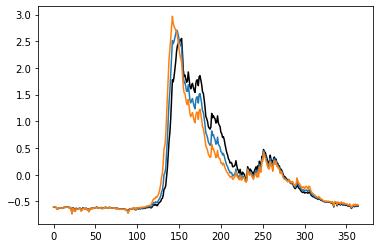

In [36]:
station = 0
days = np.arange(365)

plt.plot(y_test_predict_Tperturbs_north[days,station,0], 'k')
plt.plot(y_test_predict_Tperturbs_north[days,station,1])
plt.plot(y_test_predict_Tperturbs_north[days,station,2])

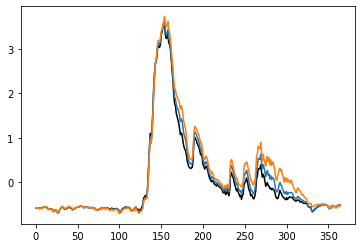

In [ ]:
station = 0
days = np.arange(365)

plt.plot(y_test_predict_Pperturbs_south[days,station,0], 'k')
plt.plot(y_test_predict_Pperturbs_south[days,station,1])
plt.plot(y_test_predict_Pperturbs_south[days,station,2])

# Calculate % Glaciation

In [31]:
dir_rgi = dir_data + '/RGI/'
# hypso_filename = '02_rgi60_WesternCanadaUS_hypso.csv'
poly_filename = '02_rgi60_WesternCanadaUS.shp'
polys = gpd.read_file(dir_rgi + poly_filename)
cenLon = polys['CenLon']
cenLat = polys['CenLat']
area = polys['Area']

In [32]:
glacier_points = [Point(lon, lat) for lon, lat in zip(cenLon, cenLat)]
glacier_area_in = np.zeros(len(stationInds))
area_glaciers_in = np.zeros(len(stationInds))

for jj, basin in enumerate(stationBasins):

  if basin is not None:

    glaciers_in = np.zeros(len(cenLon))

    for kk, point in enumerate(glacier_points):
        glaciers_in[kk] = basin.contains(point)

    glaciers_in_inds = np.squeeze(np.argwhere(glaciers_in))
    area_glaciers_in[jj] = np.sum(area[glaciers_in_inds])

stationArea = np.array([float(flowDict['stationDrainageArea'][stationInds][kk][1:]) for kk in range(len(stationInds))])
stationPG = area_glaciers_in / stationArea

In [33]:
stationArea = np.array([float(flowDict['stationDrainageArea'][stationInds][kk][1:]) for kk in range(len(stationInds))])
stationPG = area_glaciers_in / stationArea

In [34]:
del polys, cenLon, cenLat, area, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


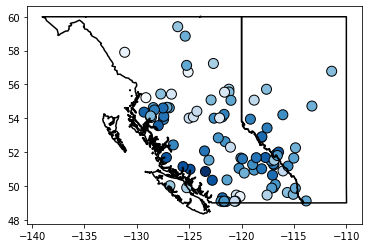

In [35]:
fig, ax = plt.subplots()

plot_prov_ax(['AB', 'BC'], ax)

plt.scatter(stationLon[stationInds], stationLat[stationInds], c = np.log(stationPG), edgecolor = 'k', s = 100, cmap = 'Blues')

# Glacier PC-space

In [37]:
#SOUTH

y_all_south = np.vstack([y_train_south, y_val_south, y_test_south])
y_all_Tpredict_south = np.vstack([y_train_predict_Tperturbs_south, y_val_predict_Tperturbs_south, y_test_predict_Tperturbs_south])
# y_all_Ppredict_south = np.vstack([y_train_predict_Pperturbs_south, y_val_predict_Pperturbs_south, y_test_predict_Pperturbs_south])

eraDate = eraDate_modern[365:13149+365]

#MODEL: calculate yearly flow (365-day long flows of each year, starting on Jan 1)

delta = timedelta(days = 364)
year_start = 1980
year_fin = 2015

f_seasonal_yearly_south_T = np.zeros((365, Nstations_south, len(range(year_start, year_fin+1)), Nperturbs_T))
# f_seasonal_yearly_P = np.zeros((365, Nstations_south, len(range(year_start, year_fin+1)), Nperturbs_P))
f_seasonal_yearly_south_obs = np.zeros((365, Nstations_south, len(range(year_start, year_fin+1))))

for perturb in range(Nperturbs_T):
  kk = 0
  for nn, year in enumerate(range(year_start, year_fin+1)):
    
    start_date = datetime(year, 1, 1)
    fin_date = start_date + delta

    start_ind = eraDate.index(start_date)
    fin_ind = eraDate.index(fin_date)

    #T
    f = y_all_Tpredict_south[start_ind:fin_ind+1,:,perturb]
    if (year==year_fin) and (np.mod(year_fin,4)==0): #if last year missing final day -- fill in with second last day
      f_new = np.zeros((365,265))
      f_new[:-1,:] = f
      f_new[-1,:] = f_new[-2,:]
      f = f_new
    f_seasonal_yearly_south_T[:,:,kk,perturb] = f

    # #P
    # f = y_all_Ppredict_south[start_ind:fin_ind+1,:,perturb]
    # if (year==year_fin) and (np.mod(year_fin,4)==0): #if last year missing final day -- fill in with second last day
    #   f_new = np.zeros((365,265))
    #   f_new[:-1,:] = f
    #   f_new[-1,:] = f_new[-2,:]
    #   f = f_new
    # f_seasonal_yearly_P[:,:,kk,perturb] = f

    kk+=1

#observations
kk=0
for nn, year in enumerate(range(year_start, year_fin+1)):
  
  start_date = datetime(year, 1, 1)
  fin_date = start_date + delta

  start_ind = eraDate.index(start_date)
  fin_ind = eraDate.index(fin_date)

  f = y_all_south[start_ind:fin_ind+1,:]

  if (year==year_fin) and (np.mod(year_fin,4)==0): #if last year missing final day -- fill in with second last day
    f_new = np.zeros((365,265))
    f_new[:-1,:] = f
    f_new[-1,:] = f_new[-2,:]
    f = f_new
  f_seasonal_yearly_south_obs[:,:,kk] = f

  kk+=1



In [38]:
#NORTH

y_all_north = np.vstack([y_train_north, y_val_north, y_test_north])
y_all_Tpredict_north = np.vstack([y_train_predict_Tperturbs_north, y_val_predict_Tperturbs_north, y_test_predict_Tperturbs_north])
# y_all_Ppredict_south = np.vstack([y_train_predict_Pperturbs_south, y_val_predict_Pperturbs_south, y_test_predict_Pperturbs_south])

eraDate = eraDate_modern[365:13149+365]

#MODEL: calculate yearly flow (365-day long flows of each year, starting on Jan 1)

delta = timedelta(days = 364)
year_start = 1980
year_fin = 2015

f_seasonal_yearly_north_T = np.zeros((365, Nstations_north, len(range(year_start, year_fin+1)), Nperturbs_T))
# f_seasonal_yearly_P = np.zeros((365, Nstations_north, len(range(year_start, year_fin+1)), Nperturbs_P))
f_seasonal_yearly_north_obs = np.zeros((365, Nstations_north, len(range(year_start, year_fin+1))))

for perturb in range(Nperturbs_T):
  kk = 0
  for nn, year in enumerate(range(year_start, year_fin+1)):
    
    start_date = datetime(year, 1, 1)
    fin_date = start_date + delta

    start_ind = eraDate.index(start_date)
    fin_ind = eraDate.index(fin_date)

    #T
    f = y_all_Tpredict_north[start_ind:fin_ind+1,:,perturb]
    if (year==year_fin) and (np.mod(year_fin,4)==0): #if last year missing final day -- fill in with second last day
      f_new = np.zeros((365,265))
      f_new[:-1,:] = f
      f_new[-1,:] = f_new[-2,:]
      f = f_new
    f_seasonal_yearly_north_T[:,:,kk,perturb] = f

    # #P
    # f = y_all_Ppredict_north[start_ind:fin_ind+1,:,perturb]
    # if (year==year_fin) and (np.mod(year_fin,4)==0): #if last year missing final day -- fill in with second last day
    #   f_new = np.zeros((365,265))
    #   f_new[:-1,:] = f
    #   f_new[-1,:] = f_new[-2,:]
    #   f = f_new
    # f_seasonal_yearly_P[:,:,kk,perturb] = f

    kk+=1

#observations
kk=0
for nn, year in enumerate(range(year_start, year_fin+1)):
  
  start_date = datetime(year, 1, 1)
  fin_date = start_date + delta

  start_ind = eraDate.index(start_date)
  fin_ind = eraDate.index(fin_date)

  f = y_all_north[start_ind:fin_ind+1,:]

  if (year==year_fin) and (np.mod(year_fin,4)==0): #if last year missing final day -- fill in with second last day
    f_new = np.zeros((365,265))
    f_new[:-1,:] = f
    f_new[-1,:] = f_new[-2,:]
    f = f_new
  f_seasonal_yearly_north_obs[:,:,kk] = f

  kk+=1



In [50]:
f_seasonal_yearly_T = np.zeros((365,Nstations,36,Nperturbs_T))
f_seasonal_yearly_T[:,stationInds_south,:,:] = f_seasonal_yearly_south_T
f_seasonal_yearly_T[:,stationInds_north,:,:] = f_seasonal_yearly_north_T

f_seasonal_yearly_obs = np.zeros((365,Nstations,36))
f_seasonal_yearly_obs[:,stationInds_south,:] = f_seasonal_yearly_south_obs
f_seasonal_yearly_obs[:,stationInds_north,:] = f_seasonal_yearly_north_obs

In [187]:
#prep for PCA

days = np.arange(213,244)
days = np.arange(150,180)
# days = np.arange(180,210)
# days = np.arange(240,270)
Ndays = len(days)

PCA_input = np.reshape(f_seasonal_yearly_obs.T, (Nstations*36, 365))
# PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
PCA_input = PCA_input[:,days]

PCA_input_mod = np.reshape(f_seasonal_yearly_T[:,:,:,1].T, (Nstations*36, 365))
# PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
PCA_input_mod = PCA_input_mod[:,days]

PCA_input_warm = np.reshape(f_seasonal_yearly_T[:,:,:,2].T, (Nstations*36, 365))
# PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
PCA_input_warm = PCA_input_warm[:,days]

PCA_input_cold = np.reshape(f_seasonal_yearly_T[:,:,:,0].T, (Nstations*36, 365))
# PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
PCA_input_cold = PCA_input_cold[:,days]

# PCA_input_wet = np.reshape(f_seasonal_yearly_P[:,:,:,2].T, (Nstations_south*36, 365))
# # PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# # PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
# PCA_input_wet = PCA_input_wet[:,days]

# PCA_input_dry = np.reshape(f_seasonal_yearly_P[:,:,:,0].T, (Nstations_south*36, 365))
# # PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# # PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
# PCA_input_dry = PCA_input_dry[:,days]

In [188]:
# #prep for PCA

# days = np.arange(213,244)
# Ndays = len(days)

# PCA_input = np.reshape(f_seasonal_yearly_obs.T, (Nstations_south*36, 365))
# # PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# # PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
# PCA_input = PCA_input[:,days]

# PCA_input_mod = np.reshape(f_seasonal_yearly_T[:,:,:,1].T, (Nstations_south*36, 365))
# # PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# # PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
# PCA_input_mod = PCA_input_mod[:,days]

# PCA_input_warm = np.reshape(f_seasonal_yearly_T[:,:,:,2].T, (Nstations_south*36, 365))
# # PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# # PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
# PCA_input_warm = PCA_input_warm[:,days]

# PCA_input_cold = np.reshape(f_seasonal_yearly_T[:,:,:,0].T, (Nstations_south*36, 365))
# # PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# # PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
# PCA_input_cold = PCA_input_cold[:,days]

# # PCA_input_wet = np.reshape(f_seasonal_yearly_P[:,:,:,2].T, (Nstations_south*36, 365))
# # # PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# # # PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
# # PCA_input_wet = PCA_input_wet[:,days]

# # PCA_input_dry = np.reshape(f_seasonal_yearly_P[:,:,:,0].T, (Nstations_south*36, 365))
# # # PCA_input -= np.expand_dims(np.mean(PCA_input, axis = -1), axis = -1)
# # # PCA_input /= np.expand_dims(np.std(PCA_input, axis = -1), axis = -1)
# # PCA_input_dry = PCA_input_dry[:,days]

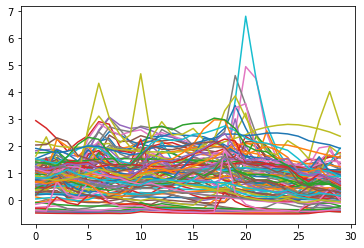

In [189]:
plt.plot(PCA_input[:100].T)
plt.show()

In [190]:
#do PCA

#develop PCA on model output (temporally complete)
n_components = 10#np.min(np.shape(PCA_input))
pca = PCA(n_components = n_components).fit(PCA_input)
frac_var = pca.explained_variance_ratio_
eigvecs = pca.components_
PCs = pca.transform(PCA_input)
PCs_mod = pca.transform(PCA_input_mod)
PCs_warm = pca.transform(PCA_input_warm)
PCs_cold = pca.transform(PCA_input_cold)
# PCs_wet = pca.transform(PCA_input_wet)
# PCs_dry = pca.transform(PCA_input_dry)

In [191]:
frac_var

array([0.50932615, 0.13404319, 0.07691335, 0.05553512, 0.05143585,
       0.04235079, 0.024036  , 0.01763504, 0.01717381, 0.01096382])

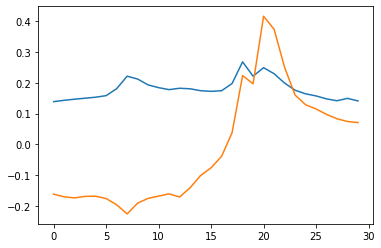

In [192]:
plt.plot(eigvecs[0])
plt.plot(eigvecs[1])

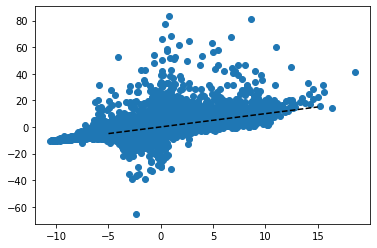

In [193]:
plt.scatter(PCs_mod, PCs)
plt.plot([-5,15],[-5,15], 'k--')

In [194]:
Nstations_south = 265

PC0_stations = np.zeros((Nstations_south, 36))
PC0_mean = np.zeros(Nstations_south)
PC0_std = np.zeros(Nstations_south)

PC0_mod_stations = np.zeros((Nstations_south, 36))
PC0_mod_mean = np.zeros(Nstations_south)
PC0_mod_std = np.zeros(Nstations_south)

PC0_warm_stations = np.zeros((Nstations_south, 36))
PC0_warm_mean = np.zeros(Nstations_south)
PC0_warm_std = np.zeros(Nstations_south)

PC0_cold_stations = np.zeros((Nstations_south, 36))
PC0_cold_mean = np.zeros(Nstations_south)
PC0_cold_std = np.zeros(Nstations_south)

PC0_wet_stations = np.zeros((Nstations_south, 36))
PC0_wet_mean = np.zeros(Nstations_south)
PC0_wet_std = np.zeros(Nstations_south)

PC0_dry_stations = np.zeros((Nstations_south, 36))
PC0_dry_mean = np.zeros(Nstations_south)
PC0_dry_std = np.zeros(Nstations_south)

for station in range(Nstations_south):

  component = 0

  inds = np.arange(station, Nstations_south*36, Nstations_south)
  PC0_stations[station,:] = PCs[inds,component]
  PC0_mean[station] = np.mean(PC0_stations[station,:])
  PC0_std[station] = np.std(PC0_stations[station,:])

  PC0_mod_stations[station,:] = PCs_mod[inds,component]
  PC0_mod_mean[station] = np.mean(PC0_mod_stations[station,:])
  PC0_mod_std[station] = np.std(PC0_mod_stations[station,:])

  PC0_warm_stations[station,:] = PCs_warm[inds,component]
  PC0_warm_mean[station] = np.mean(PC0_warm_stations[station,:])
  PC0_warm_std[station] = np.std(PC0_warm_stations[station,:])

  PC0_cold_stations[station,:] = PCs_cold[inds,component]
  PC0_cold_mean[station] = np.mean(PC0_cold_stations[station,:])
  PC0_cold_std[station] = np.std(PC0_cold_stations[station,:])

  # PC0_wet_stations[station,:] = PCs_wet[inds,component]
  # PC0_wet_mean[station] = np.mean(PC0_wet_stations[station,:])
  # PC0_wet_std[station] = np.std(PC0_wet_stations[station,:])

  # PC0_dry_stations[station,:] = PCs_dry[inds,component]
  # PC0_dry_mean[station] = np.mean(PC0_dry_stations[station,:])
  # PC0_dry_std[station] = np.std(PC0_dry_stations[station,:])


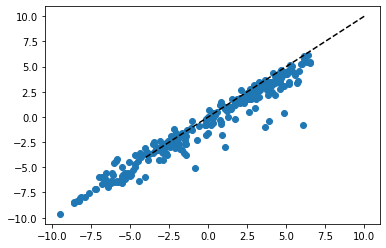

In [195]:
plt.scatter(PC0_mean, PC0_mod_mean)
plt.plot([-4,10],[-4,10], 'k--')

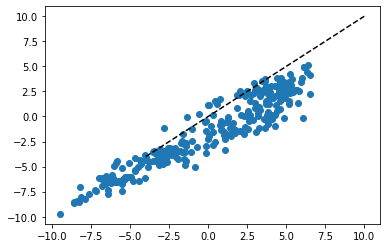

In [196]:
plt.scatter(PC0_mean, PC0_warm_mean)
plt.plot([-4,10],[-4,10], 'k--')

In [197]:
len(PC0_mean)

265

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


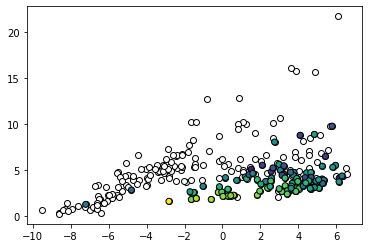

In [198]:
plt.scatter(PC0_mean, PC0_std, edgecolor =  'k', facecolor = 'w')
# plt.scatter(PC0_mean[stationInds_north], PC0_std[stationInds_north], edgecolor =  'k')
plt.scatter(PC0_mean, PC0_std, c = np.log(stationPG[stationInds]), edgecolor = 'k')

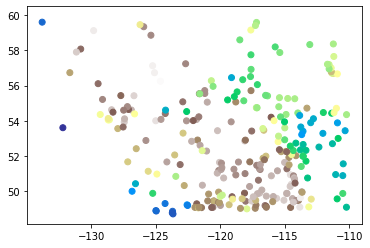

In [201]:
plt.scatter(stationLon, stationLat, c = PC0_mean, cmap = 'terrain')

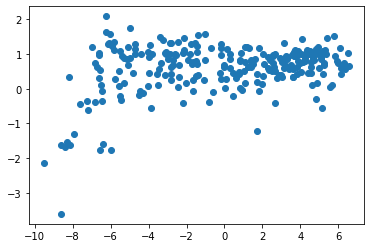

In [202]:
plt.scatter(PC0_mean, np.log(mag))

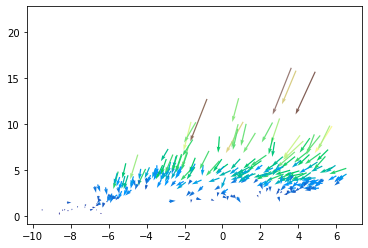

In [203]:
dPC0_mean = PC0_warm_mean - PC0_mean
dPC0_std = PC0_warm_std - PC0_std
mag = np.sqrt(dPC0_mean**2 + dPC0_std**2)
cmap = cm.get_cmap('terrain')
norm = matplotlib.colors.Normalize(vmin = np.min(mag), vmax = np.max(mag))
plt.quiver(PC0_mean, PC0_std, dPC0_mean, dPC0_std, color = cmap(norm(mag)))

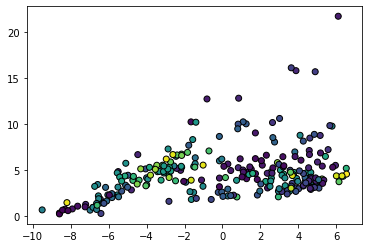

In [204]:
plt.scatter(PC0_mean, PC0_std, edgecolor =  'k', c = stationLat)

In [205]:
PC0_mean_Tperturbs = np.zeros((Nstations_south, Nperturbs_T))
PC0_mean_Tperturbs[:,0] = PC0_cold_mean
PC0_mean_Tperturbs[:,1] = PC0_mean
PC0_mean_Tperturbs[:,2] = PC0_warm_mean

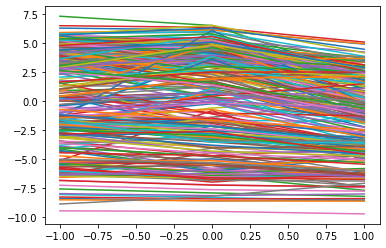

In [206]:
plt.plot(T_perturbs, PC0_mean_Tperturbs.T)#[0,:])
plt.show()

In [207]:
d_warm = PC0_warm_mean - PC0_cold_mean
d_wet = PC0_wet_mean - PC0_dry_mean

In [208]:
stationInds_south = stationInds

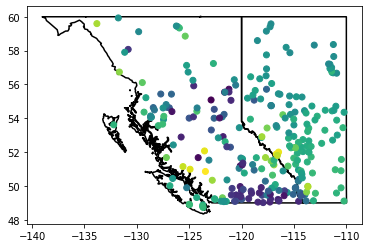

In [209]:
fig, ax = plt.subplots()

plot_prov_ax(prov = prov, ax = ax)
ax.scatter(stationLon[stationInds_south], stationLat[stationInds_south], c = d_warm, zorder = 5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


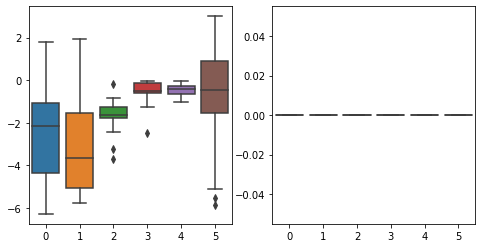

In [210]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
sns.boxplot(seasonal_clustering.labels_, d_warm, ax = ax[0])
sns.boxplot(seasonal_clustering.labels_, d_wet, ax = ax[1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


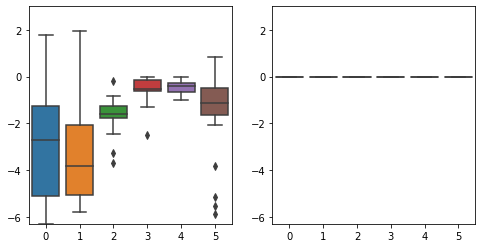

In [211]:
inds = np.argwhere(stationPG[stationInds]<0.01).squeeze()

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
sns.boxplot(seasonal_clustering.labels_[inds], d_warm[inds], ax = ax[0])
sns.boxplot(seasonal_clustering.labels_[inds], d_wet[inds], ax = ax[1])

for aa in ax.flatten():
  aa.set_ylim(bottom = np.min([d_warm, d_wet]), top = np.max([d_warm, d_wet]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


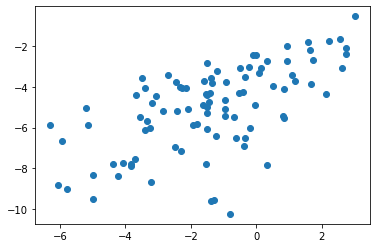

In [212]:
plt.scatter(d_warm, np.log(stationPG[stationInds_south]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


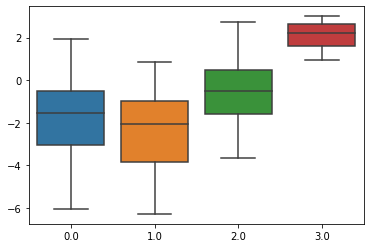

In [213]:
glacier_class = 3*np.ones(Nstations_south)
glacier_class[stationPG[stationInds_south]<=0.1] = 2
glacier_class[stationPG[stationInds_south]<=0.01] = 1
glacier_class[stationPG[stationInds_south]==0] = 0

sns.boxplot(glacier_class, d_warm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


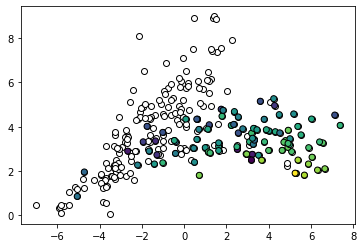

In [180]:
plt.scatter(PC0_mean, PC0_std, edgecolor =  'k', facecolor = 'w')
plt.scatter(PC0_mean, PC0_std, c = np.log(stationPG[stationInds_south]), edgecolor = 'k')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


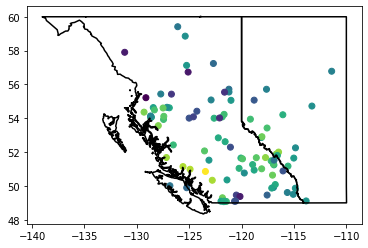

In [181]:
fig, ax = plt.subplots()

plot_prov_ax(prov = prov, ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], c = np.log(stationPG))

In [182]:
#cluster PC time series



In [183]:
from scipy.cluster.hierarchy import dendrogram, linkage

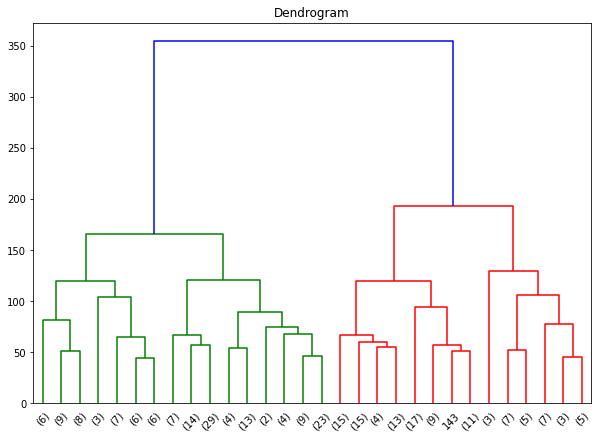

In [184]:
data = np.copy(PC0_stations)
linked = linkage(data,'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp',
           p=30)
plt.title('Dendrogram')
plt.show()

In [185]:
#now cluster

data = PC0_stations

n_clusters = 4
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  affinity='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(data)

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(cn==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)

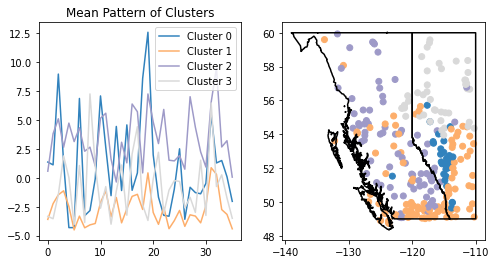

In [186]:
#visualize clusters

norm = matplotlib.colors.Normalize(vmin = 0, vmax = n_clusters-1)
cmap = cm.get_cmap('tab20c')

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

for kk in range(n_clusters):
  axes[0].plot(cluster_pattern[kk], color = cmap(norm(kk)))

axes[0].set_title('Mean Pattern of Clusters')
axes[0].legend(['Cluster ' + str(ii) for ii in range(n_clusters)])

plot_prov_ax(prov = prov, ax = axes[1])
axes[1].scatter(stationLon[stationInds], stationLat[stationInds], c = cn, cmap = cmap)

plt.show()

# Prep data (south): 1950 - 1978 Hindcast

In [ ]:
# #first, delete high-memory old data
# del x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
evapDict = pickle.load(pickle_in)

#unpack data
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])
E = np.asarray(evapDict['E'])
PE = P+E

eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_hind = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

del tempDict, precDict, evapDict

#restrict to region of interest determined above
Tmax = Tmax[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
Tmin = Tmin[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
P = P[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
E = E[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
PE = PE[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]

#standardize data relative to training time period

#years/indices of hindcast
hindStartYear = 1950
hindFinYear = 1978

hindInds = np.arange(len(eraDays)-1)
Nhind = len(hindInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxnorm = (Tmax - Tmaxmean_train_south)/Tmaxstd_train_south
Tmaxnorm = np.single(Tmaxnorm)

Tminnorm = (Tmin - Tminmean_train_south)/Tminstd_train_south
Tminnorm = np.single(Tminnorm)

Pnorm = (P - Pmean_train_south)/Pstd_train_south
Pnorm = np.single(Pnorm)

Enorm = (E - Emean_train_south)/Estd_train_south
Enorm = np.single(Enorm)

PEnorm = (PE - PEmean_train_south)/PEstd_train_south
PEnorm = np.single(PEnorm)

Tminnorm = Tminnorm[:-1]
Tmaxnorm = Tmaxnorm[:-1]

#construct train and test predictor tensors

#predictor data
nchannels = 3 
x_hind = np.empty((Nhind-365,365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Pnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#hindcast
for ii in range(Nhind-365):
  x_hind[ii] = x_intermediate[ii:ii+365]

#convert predict/target arrays to tensors
x_hind = tf.convert_to_tensor(x_hind)

# Predict streamflow (south): 1950 - 1978

In [ ]:
#predict and save streamflow hindcast data

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]

#initialize
y_hind_predict_fine_runs = np.empty((len(runs), Nhind-365, len(stationInds_south))) #fine-tuned model predictions of each run
y_hind_predict_fine = np.empty((Nhind-365, len(stationInds_south))) #fine-tuned model predictions of each run

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  for cluster in range(n_clusters_seasonal_south):
    
    print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal_south))

    stations_fine = np.squeeze(np.argwhere(seasonal_clustering_south.labels_ == cluster)) #stations in this cluster
    N_stations = len(stations_fine) #number of stations in this cluster

    #load model
    model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
    model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

    y_hind_intermediate = model_fine.predict(x_hind, verbose = 0)

    for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
        # y_hind_predict_fine_runs[run,:,station] = y_hind_intermediate[:,zz]
        y_hind_predict_fine[:,station] = y_hind_intermediate[:,zz]

  # #save fine-tuned model predictions
  # file_hind = 'y_hind_fine_predict_' + str(ii) + '.csv'
  # np.savetxt(dir_output + '/' + file_hind, y_hind_predict_fine, delimiter = ',')


# Prep data (north): 1950 - 1978 Hindcast

In [ ]:
#first, delete high-memory old data
del x_intermediate, x_hind

In [ ]:
#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#load daily evaporation data
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
evapDict = pickle.load(pickle_in)

#unpack data
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])
E = np.asarray(evapDict['E'])
PE = P+E

eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_hind = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

del tempDict, precDict, evapDict

#restrict to region of interest determined above
Tmax = Tmax[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
Tmin = Tmin[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
P = P[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
E = E[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
PE = PE[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]

#standardize data relative to training time period

#years/indices of hindcast
hindStartYear = 1950
hindFinYear = 1978

hindInds = np.arange(len(eraDays)-1)
Nhind = len(hindInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxnorm = (Tmax - Tmaxmean_train_north)/Tmaxstd_train_north
Tmaxnorm = np.single(Tmaxnorm)

Tminnorm = (Tmin - Tminmean_train_north)/Tminstd_train_north
Tminnorm = np.single(Tminnorm)

Pnorm = (P - Pmean_train_north)/Pstd_train_north
Pnorm = np.single(Pnorm)

Enorm = (E - Emean_train_north)/Estd_train_north
Enorm = np.single(Enorm)

PEnorm = (PE - PEmean_train_north)/PEstd_train_north
PEnorm = np.single(PEnorm)

Tminnorm = Tminnorm[:-1]
Tmaxnorm = Tmaxnorm[:-1]

#construct train and test predictor tensors

#predictor data
nchannels = 3 
x_hind = np.empty((Nhind-365,365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Pnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#hindcast
for ii in range(Nhind-365):
  x_hind[ii] = x_intermediate[ii:ii+365]

#convert predict/target arrays to tensors
x_hind = tf.convert_to_tensor(x_hind)

# Predict streamflow (north): 1950 - 1978

In [ ]:
#predict and save streamflow hindcast data

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]

#initialize
y_hind_predict_fine_runs = np.empty((len(runs), Nhind-365, len(stationInds_north))) #fine-tuned model predictions of each run
y_hind_predict_fine = np.empty((Nhind-365, len(stationInds_north))) #fine-tuned model predictions of each run

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  if ii > 4:

    print('Run ' + str(run))

    for cluster in range(n_clusters_seasonal_north):
      
      print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal_north))

      stations_fine = np.squeeze(np.argwhere(seasonal_clustering_north.labels_ == cluster)) #stations in this cluster
      N_stations = len(stations_fine) #number of stations in this cluster

      #load model
      model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
      model_fine = tf.keras.models.load_model(dir_models_north + '/' + model_name)

      y_hind_intermediate = model_fine.predict(x_hind, verbose = 0)

      for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
          # y_hind_predict_fine_runs[run,:,station] = y_hind_intermediate[:,zz]
          y_hind_predict_fine[:,station] = y_hind_intermediate[:,zz]

    #save fine-tuned model predictions
    file_hind = 'y_hind_fine_predict_' + str(ii) + '.csv'
    np.savetxt(dir_output_north + '/' + file_hind, y_hind_predict_fine, delimiter = ',')


Run 5
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2
Run 6
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2
Run 7
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2
Run 8
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2
Run 9
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2


# Load model streamflow: 1950 - 2015

In [ ]:
del x_intermediate, x_hind

In [ ]:
Ntest = int(Ntest*2)

In [ ]:
#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]

#initialize
y_train_predict_fine_runs = np.empty((len(runs), Ntrain-365, len(stationInds))) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((len(runs), Nval, len(stationInds))) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run
y_hind_predict_fine_runs = np.empty((len(runs), Nhind-365, len(stationInds))) #fine-tuned model predictions of each run

y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  filename_hind_fine = 'y_hind_fine_predict_' + str(run) + '.csv'
  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

### SOUTH

  y_hind_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_hind_fine, header = None))
  # y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  # y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  # y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))
  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_train_fine, header = None))[:,stationInds_south]
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_val_fine, header = None))[:,stationInds_south]
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_test_fine, header = None))[:,stationInds_south]

  y_hind_predict_fine_runs[ii,:,stationInds_south] = y_hind_predict_fine.T
  y_train_predict_fine_runs[ii,:,stationInds_south] = y_train_predict_fine.T
  y_val_predict_fine_runs[ii,:,stationInds_south] = y_val_predict_fine.T
  y_test_predict_fine_runs[ii,:,stationInds_south] = y_test_predict_fine.T

### NORTH

  y_hind_predict_fine = np.asarray(pd.read_csv(dir_output_north + '/' + filename_hind_fine, header = None))
  # y_train_predict_fine = np.asarray(pd.read_csv(dir_output_north + '/' + filename_train_fine, header = None))
  # y_val_predict_fine = np.asarray(pd.read_csv(dir_output_north + '/' + filename_val_fine, header = None))
  # y_test_predict_fine = np.asarray(pd.read_csv(dir_output_north + '/' + filename_test_fine, header = None))
  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_train_fine, header = None))[:,stationInds_north]
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_val_fine, header = None))[:,stationInds_north]
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_test_fine, header = None))[:,stationInds_north]

  y_hind_predict_fine_runs[ii,:,stationInds_north] = y_hind_predict_fine.T
  y_train_predict_fine_runs[ii,:,stationInds_north] = y_train_predict_fine.T
  y_val_predict_fine_runs[ii,:,stationInds_north] = y_val_predict_fine.T
  y_test_predict_fine_runs[ii,:,stationInds_north] = y_test_predict_fine.T

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [ ]:
y_hind_predict = np.mean(y_hind_predict_fine_runs, axis = 0)
y_train_predict = np.mean(y_train_predict_fine_runs, axis = 0)
y_val_predict = np.mean(y_val_predict_fine_runs, axis = 0)
y_test_predict = np.mean(y_test_predict_fine_runs, axis = 0)
y_modern_predict = np.vstack([y_train_predict, y_val_predict, y_test_predict])

y_hind_std = np.std(y_hind_predict_fine_runs, axis = 0)
y_train_std = np.std(y_train_predict_fine_runs, axis = 0)
y_val_std = np.std(y_val_predict_fine_runs, axis = 0)
y_test_std = np.std(y_test_predict_fine_runs, axis = 0)
y_modern_std = np.vstack([y_train_std, y_val_std, y_test_std])

# Load observations: 1950 - 2015

In [ ]:
flowpickle = ['BC_flowvars_1950_2015_missing_10_10_0.pickle', 'AB_flowvars_1950_2015_missing_10_10_0.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

flowpickle = ['BC_flowvars_1950_2020_missing_10_10_0.pickle', 'AB_flowvars_1950_2020_missing_10_10_0.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict_long = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#unpack data
stationLat_long = flowDict_long['stationLat']
stationLon_long = flowDict_long['stationLon']

flowDays_long = flowDict_long['windowDays']
flowMonths_long = flowDict_long['windowMonths']
flowYears_long = flowDict_long['windowYears']

date_str = [str(int(flowDays_long[kk])) + '-' +  str(int(flowMonths_long[kk])) + '-' + str(int(flowYears_long[kk])) for kk in range(len(flowYears_long))]
flowDate_long = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

F_long = np.squeeze(flowDict_long['all_flow']).T
stationNames_long = flowDict_long['stationName']


In [ ]:
# del flowDict

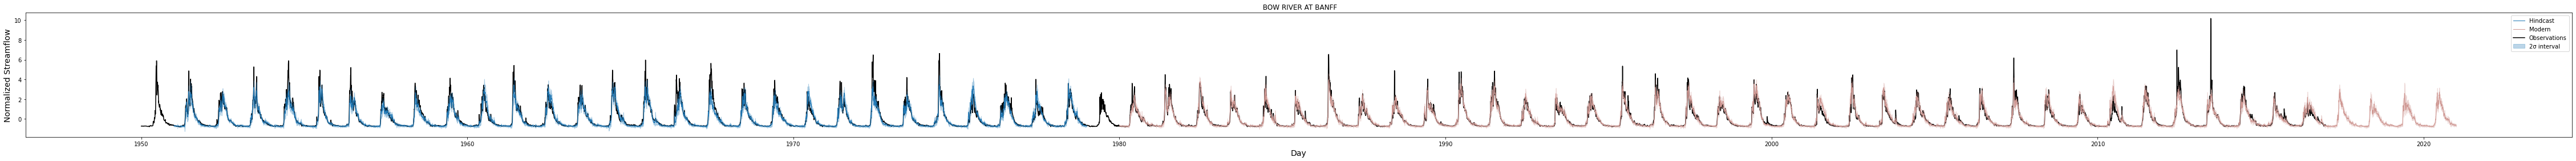

In [ ]:
saveIt = 0

fs = 14

#ELK: 109
#BANFF: 141
#PEMBINA:
#CHEMAINUS: 31
#PEMBINA: 206
ind = 157
stationName = stationNames[ind]

ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))
rgb = '#1f77b4' #colour for shading that I like (picked from coolors.co)
rgb_mod = '#CF9893'

fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (80,4))

fb_hind1 = y_hind_predict[:,ind] - 2*y_hind_std[:,ind]
fb_hind2 = y_hind_predict[:,ind] + 2*y_hind_std[:,ind]

fb_mod1 = y_modern_predict[:,ind] - 2*y_modern_std[:,ind]
fb_mod2 = y_modern_predict[:,ind] + 2*y_modern_std[:,ind]

#hindcast model
ax.plot(eraDate_hind[365:-1], y_hind_predict[:,ind], label = 'Hindcast', color = rgb, linewidth = 1)
ax.fill_between(eraDate_hind[365:-1], fb_hind1, fb_hind2, alpha = 0.3, label = '2\u03C3 interval', color = rgb)

#modern model
ax.plot(eraDate_modern[365:-1], y_modern_predict[:,ind], label = 'Modern', color = rgb_mod, linewidth = 1)
ax.fill_between(eraDate_modern[365:-1], fb_mod1, fb_mod2, alpha = 0.3, color = rgb_mod)

#entire observation
ax.plot(flowDate_long, (F_long[:,ind_long] - Fmean[ind]) / Fstd[ind], 'k', label = 'Observations', zOrder = 0)

ax.set_ylabel('Normalized Streamflow', fontsize = fs)
ax.set_xlabel('Day', fontsize = fs)
ax.set_title(stationNames[ind])
ax.legend(fontsize = fs-4)

# ax.set_xlim((
#     datetime(2001,1,1),
#     datetime(2009,1,1)
# ))

if saveIt:
  plt.savefig(stationNames[ind] + '_hind_modern.png', bbox_inches = 'tight', dpi = 250)

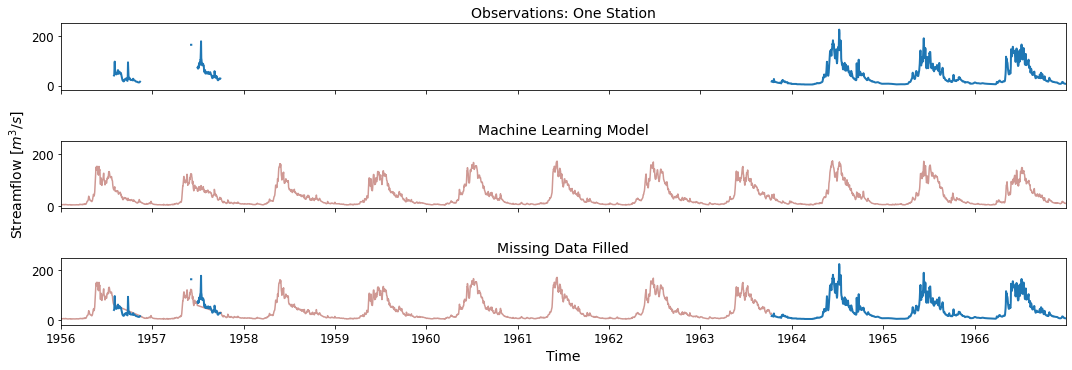

In [ ]:
saveIt = 0

ind = 93

stationName = stationNames[ind]
ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

rgb_obs = '#1f77b4' #colour for shading that I like (picked from coolors.co)
rgb_mod = '#CF9893'

nrows = 3
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15*ncols, 1.75*nrows))

year_start = 1956
year_fin = 1966
dt_start = datetime(year = year_start, month = 1, day = 1)
dt_fin = datetime(year = year_fin, month = 12, day = 31)
ymax = 250#np.nanmax(F_long[:,ind_long])

#observations
axes[0].plot(flowDate_long, F_long[:,ind_long], color = rgb_obs, label = 'Observations', linewidth = 2)
axes[0].set_xlim(left = dt_start, right = dt_fin)
axes[0].set_ylim(top = ymax)
axes[0].set_title('Observations: One Station', fontsize = fs)

#model
axes[1].plot(eraDate_hind[365:-1], y_hind_predict[:,ind]*Fstd[ind] + Fmean[ind], label = 'Model', color = rgb_mod)
axes[1].set_xlim(left = dt_start, right = dt_fin)
axes[1].set_ylim(top = ymax)
axes[1].set_title('Machine Learning Model', fontsize = fs)
axes[1].set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)

#obsermodelvations
missing_inds = np.squeeze(np.argwhere(np.isnan(F_long[:6000,ind_long])))
axes[2].plot(flowDate_long, F_long[:,ind_long], color = rgb_obs, label = 'Observations', zOrder = 0, linewidth = 2)
axes[2].plot([eraDate_hind[kk] for kk in missing_inds], y_hind_predict[-365+missing_inds,ind]*Fstd[ind] + Fmean[ind], color = rgb_mod, zOrder = -1)
axes[2].set_xlim(left = dt_start, right = dt_fin)
axes[2].set_ylim(top = ymax)
axes[2].set_title('Missing Data Filled', fontsize = fs)
axes[2].set_xlabel('Time', fontsize = fs)

axes[0].tick_params(labelbottom = False, labelsize = fs - 2)
axes[1].tick_params(labelbottom = False, labelsize = fs - 2)
axes[2].tick_params(labelsize = fs - 2)

plt.tight_layout()

if saveIt:
  plt.savefig('missing_data_filled_example.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [ ]:
#fraction missing data during period 1950 - 1978
hind_missing = np.zeros(len(stationInds))
start = flowDate_long.index(datetime(1951,1,1))
fin = flowDate_long.index(datetime(1978,12,31))
for kk, stationName in enumerate(stationNames):
  ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))
  Nnan = len(np.argwhere(np.isnan(F_long[start:fin, ind_long])))
  Ndays = len(F_long[start:fin, ind_long])
  hind_missing[kk] = Nnan / Ndays

#yearly fraction missing data during period 1950 - 1978
yrs = range(1951, 2021)
hind_missing_yearly = np.zeros((len(stationInds), len(yrs)))
for kk, stationName in enumerate(stationNames):
  ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))
  for jj, yr in enumerate(yrs):
    start = flowDate_long.index(datetime(yr,1,1))
    fin = flowDate_long.index(datetime(yr,12,31))
    Nnan = len(np.argwhere(np.isnan(F_long[start:fin, ind_long])))
    Ndays = len(F_long[start:fin, ind_long])
    hind_missing_yearly[kk,jj] = Nnan / Ndays

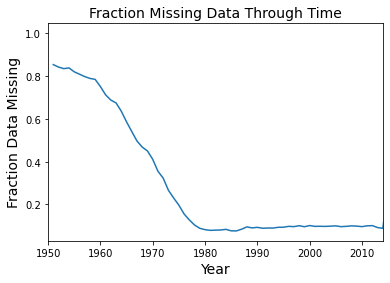

In [ ]:
#fraction missing data in time

saveIt = 0

fs = 14

fig, ax = plt.subplots()
ax.plot(yrs, np.mean(hind_missing_yearly, axis = 0))
ax.set_xlabel('Year', fontsize = fs)
ax.set_ylabel('Fraction Data Missing', fontsize = fs)
ax.set_title('Fraction Missing Data Through Time', fontsize = fs)
ax.set_xlim((1950,2014))

if saveIt:
  plt.savefig('missing_data_in_time.png', dpi = 300, bbox_inches = 'tight')

plt.show()

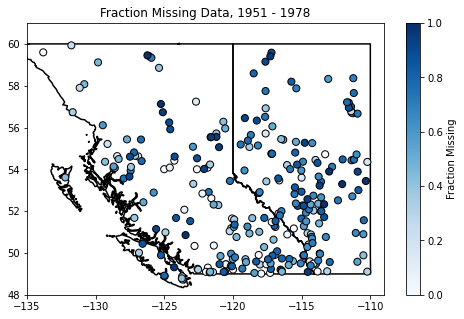

In [ ]:
#fraction missing data in space

saveIt = 0

fig, ax = plt.subplots(figsize = (8,5))
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], c = hind_missing, cmap = 'Blues', linewidth = 1, edgecolor = 'k', s = 50, zOrder = 3)
plot_prov_ax(prov, ax)
cb = plt.colorbar(s)
cb.set_label('Fraction Missing')
ax.set_title('Fraction Missing Data, 1951 - 1978')
ax.set_xlim((-135,-109))
ax.set_ylim((48,61))

if saveIt:
  plt.savefig('frac_missing_hindcast.png', bbox_inches = 'tight', dpi = 300)

plt.show()

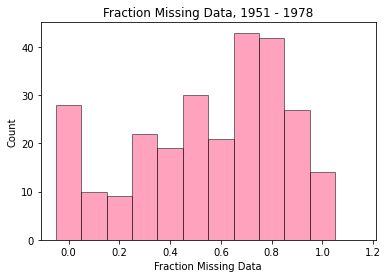

In [ ]:
#fraction missing data histogram

saveIt = 0

dbin = 0.1
bins = np.arange(-0.5*dbin,1+2*dbin, dbin)

plt.hist(hind_missing, bins = bins, edgecolor = 'k', alpha = 0.5, facecolor = '#FF477E')
plt.title('Fraction Missing Data, 1951 - 1978')
plt.xlabel('Fraction Missing Data')
plt.ylabel('Count')

if saveIt:
  plt.savefig('frac_missing_hindcast_hist.png', bbox_inches = 'tight', dpi = 300)

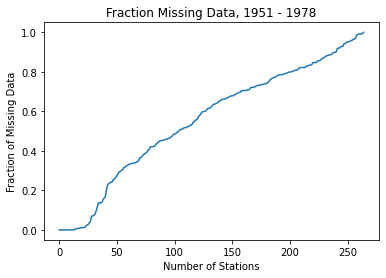

In [ ]:
#fraction missing vs number of stations

plt.plot(np.sort(hind_missing))
plt.xlabel('Number of Stations')
plt.ylabel('Fraction of Missing Data')
plt.title('Fraction Missing Data, 1951 - 1978')

plt.show()

# Evaluate model performance

In [ ]:
eraDate_hind = eraDate_hind[365:]
eraDate_modern = eraDate_modern[365:]

In [ ]:
start_obs = flowDate_long.index(datetime(1951,1,1))
fin_obs = flowDate_long.index(datetime(1978,12,31))

start_model = eraDate_hind.index(datetime(1951,1,1))
fin_model = eraDate_hind.index(datetime(1978,12,31))

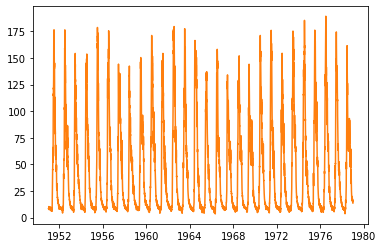

In [ ]:
dd = np.array(eraDate_hind[start_model:fin_model])
station = 141
stationName = stationNames[station]
station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

# y_obs = F_long[start_obs:fin_obs, station_long]
y_obs = F_long[start_obs:fin_obs, station]
y_model = y_hind_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

plt.plot(dd, y_obs)
plt.plot(dd, y_model)

In [ ]:
NSE_hind = np.zeros(len(stationInds))
NSE_modern = np.zeros(len(stationInds))

frac_max_missing_data = 1.#18/28
full_stations = np.squeeze(np.argwhere(hind_missing <= frac_max_missing_data))

for station in range(len(stationInds)):

  if hind_missing[station] < frac_max_missing_data:
    # print(station)

    stationName = stationNames[station]
    station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

    ### hindcast NSE

    start_obs = flowDate_long.index(datetime(1951,1,1))
    fin_obs = flowDate_long.index(datetime(1978,12,31))

    start_model = eraDate_hind.index(datetime(1951,1,1))
    fin_model = eraDate_hind.index(datetime(1978,12,31))

    dd = np.array(eraDate_hind[start_model:fin_model])

    y_obs = F_long[start_obs:fin_obs, station_long]
    # y_obs = F_long[start_obs:fin_obs, station]
    y_model = y_hind_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

    inds = np.squeeze(np.argwhere(np.isfinite(y_obs)))

    NSE_hind[station] = nse(y_obs = y_obs[inds],
                            y_model = y_model[inds])
    
    ### modern NSE

    start_obs = flowDate_long.index(datetime(1980,1,1))
    fin_obs = flowDate_long.index(datetime(2015,12,31))

    start_model = eraDate_modern.index(datetime(1980,1,1))
    fin_model = eraDate_modern.index(datetime(2015,12,31))

    start_obs = flowDate_long.index(datetime(2011,1,1))
    fin_obs = flowDate_long.index(datetime(2015,12,31))

    start_model = eraDate_modern.index(datetime(2011,1,1))
    fin_model = eraDate_modern.index(datetime(2015,12,31))

    dd = np.array(eraDate_hind[start_model:fin_model])

    y_obs = F_long[start_obs:fin_obs, station_long]
    # y_obs = F_long[start_obs:fin_obs, station]
    y_model = y_modern_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

    inds = np.squeeze(np.argwhere(np.isfinite(y_obs)))

    NSE_modern[station] = nse(y_obs = y_obs[inds],
                            y_model = y_model[inds])

dNSE = NSE_hind - NSE_modern

(array([  1.,   0.,   0.,   1.,  13.,  34.,  40.,  28.,  48., 100.]),
 array([-0.77263469, -0.599806  , -0.42697731, -0.25414862, -0.08131993,
         0.09150876,  0.26433745,  0.43716614,  0.60999483,  0.78282352,
         0.95565221]),
 <a list of 10 Patch objects>)

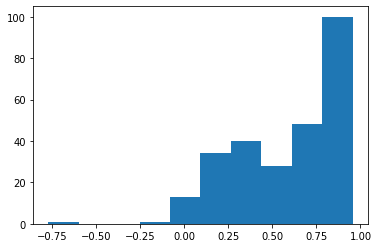

In [ ]:
plt.hist(NSE_modern)

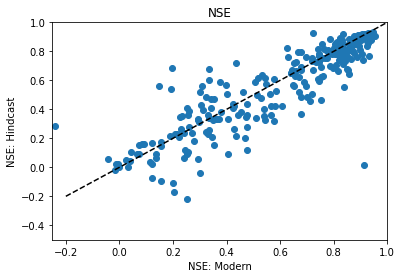

In [ ]:
#compare NSE between modern/hindcast

saveIt = 0

plt.scatter(NSE_modern[full_stations], NSE_hind[full_stations])
plt.plot([-0.2,1],[-0.2,1], 'k--')
plt.ylim((-0.5,1))
plt.xlim((-0.25, 1))
plt.xlabel('NSE: Modern')
plt.ylabel('NSE: Hindcast')
plt.title('NSE')

if saveIt:
  plt.savefig('NSE_modern_hind_scatter.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [ ]:
# #details for plotting/visualizations 

# #determine RGB values of colormap to use: chosen from coolors.co
# rgbs = [[241, 135, 1], #cluster 0
#       [205, 223, 160], #cluster 1
#       [159, 222, 249], #etc
#       [233, 134, 207],
#       [21, 96, 121],
#       [100, 23, 35],
#       [250, 200, 205],
#       [177, 15, 46]]

# rgbas = [[241, 135, 1,256],
#       [205, 223, 160,256],
#       [159, 222, 249,256],
#       [233, 134, 207,256],
#       [21, 96, 121,256],
#       [100, 23, 35,256],
#       [250, 200, 205, 256],
#       [177, 15, 46, 256]]

# rgbs_array = np.asarray(rgbs)/256
# rgbas_array = np.asarray(rgbas)/256

# #colours of each station
# cStations = np.empty((len(stationInds), 3))
# for kk in range(len(stationInds)):
#   cStations[kk,:] = rgbs[int(labels[kk])]
# cStations /= 256

# #assign geographically relevant names for each cluster
# cluster_names = [
#                  'Central',       #cluster 0
#                  'Southern',      #cluster 1
#                  'Eastern',       #etc
#                  'Coastal',
#                  'North-Western',
#                  'North-Eastern',
#                  'Far North-West',
#                  'Far North-East'
# ]

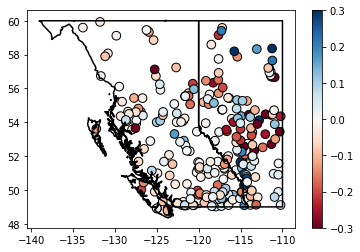

In [ ]:
fig, ax = plt.subplots()
plot_prov_ax(prov = prov, ax = ax)
s = ax.scatter(stationLon[stationInds][full_stations], 
               stationLat[stationInds][full_stations], 
               c = dNSE[full_stations], 
               s = 75,
               edgecolor = 'k',
               cmap = 'RdBu',
               vmin = -0.3, 
               vmax = 0.3)#vmin = -0.5, vmax = 1, )
fig.colorbar(s)

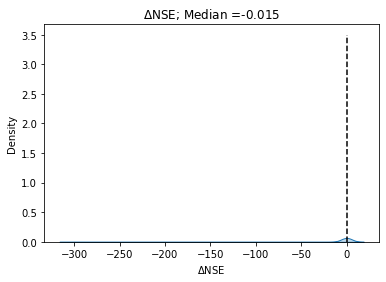

In [ ]:
#dNSE distribution

saveIt = 0

xx = np.sort(dNSE[full_stations])#[2:]
dNSE_median = np.median(dNSE[full_stations])

fig, ax = plt.subplots()
kde = sns.kdeplot(xx, ax = ax, shade = True)
ax.plot([dNSE_median,dNSE_median],[0, 3.5], 'k--')
ax.set_ylim(bottom = 0)
ax.set_xlabel('$\Delta$NSE')
ax.set_title('$\Delta$NSE; Median =' + str(np.round(dNSE_median, decimals = 3)))

if saveIt:
  plt.savefig('dNSE_kde.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
full_glaciers = np.intersect1d(full_stations, np.argwhere(stationPG>0))
full_no_glaciers = np.intersect1d(full_stations, np.argwhere(stationPG==0))

In [ ]:
dNSE_glaciers_median = np.median(dNSE[full_glaciers])
dNSE_no_glaciers_median = np.median(dNSE[full_no_glaciers])
dNSE_glaciers_median, dNSE_no_glaciers_median, dNSE_median

(-0.01757730168847238, -0.0024639587916815975, -0.0089421032144682)

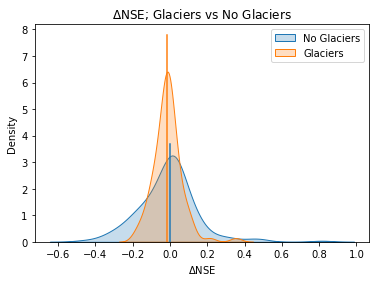

In [ ]:
#compare non-glacier-fed to glacier-fed

saveIt = 0

fig, ax = plt.subplots()
xx = np.sort(dNSE[full_no_glaciers])[2:]
dNSE_median = np.median(dNSE[full_no_glaciers])
kde = sns.kdeplot(xx, ax = ax, shade = True, label = 'No Glaciers')
ax.plot([dNSE_median,dNSE_median],[0, 3.7])#, 'k--')

xx = np.sort(dNSE[full_glaciers])[2:]
dNSE_median = np.median(dNSE[full_glaciers])
kde = sns.kdeplot(xx, ax = ax, shade = True, label = 'Glaciers')
ax.plot([dNSE_median,dNSE_median],[0, 7.8])#, 'k--')

plt.legend()
ax.set_xlabel('$\Delta$NSE')
ax.set_title('$\Delta$NSE; Glaciers vs No Glaciers')

if saveIt:
  plt.savefig('dNSE_kde_non_glacier_vs_glacier.png', bbox_inches = 'tight', dpi = 300)

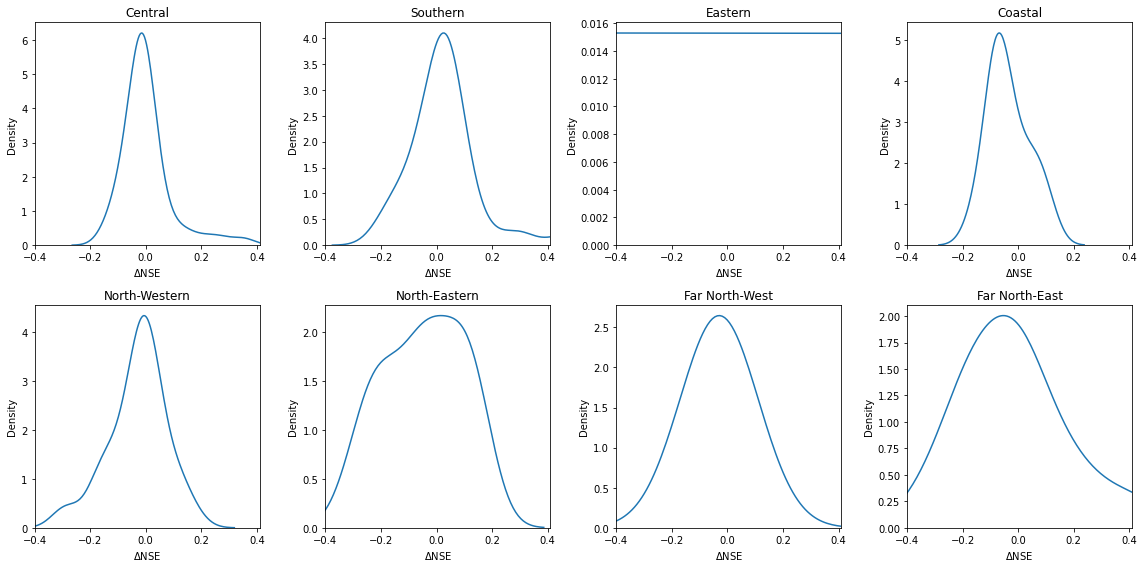

In [ ]:
nrows = 2
ncols = 4

fix, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):
  cluster_inds = np.squeeze(np.argwhere(labels == cluster))
  kde = sns.kdeplot(dNSE[cluster_inds], ax = ax)#, color = rgbas_array[cluster,:], fill = True, alpha = 0.5, edgecolor = 'k')
  ax.set_xlim((-0.4,0.41))
  ax.set_title(cluster_names[cluster])
  ax.set_xlabel('$\Delta$NSE')

plt.tight_layout()


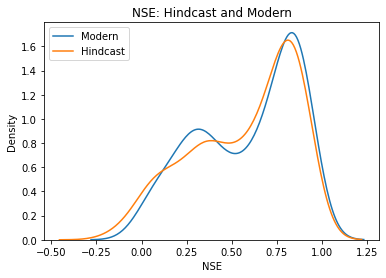

In [ ]:
sns.kdeplot(NSE_modern[full_stations][NSE_modern[full_stations]>np.sort(NSE_modern[full_stations])[2]], label = 'Modern')
sns.kdeplot(NSE_hind[full_stations][NSE_hind[full_stations]>np.sort(NSE_hind[full_stations])[2]], label = 'Hindcast')
plt.xlabel('NSE')
plt.title('NSE: Hindcast and Modern')
plt.legend()

plt.show()

(array([ 4., 18., 13., 17., 26., 20., 20., 26., 44., 54., 18.,  0.]),
 array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,
         1. ,  1.1]),
 <a list of 12 Patch objects>)

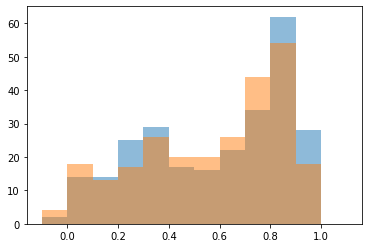

In [ ]:
bins = np.arange(-0.1,1.1,0.1)
plt.hist(NSE_modern, bins = bins, alpha = 0.5)
plt.hist(NSE_hind, bins = bins, alpha = 0.5)
